# Histopathologic Cancer Detection

The goal of this project is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

This project was built as a submission to the Kaggle competition: https://www.kaggle.com/c/histopathologic-cancer-detection/overview

## Setup

In [ ]:
import kagglehub

kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
histopathologic_cancer_detection_path = kagglehub.competition_download('histopathologic-cancer-detection')
print('dataset downloaded')

100%|██████████| 6.31G/6.31G [02:39<00:00, 42.4MB/s]

Extracting files...


dataset downloaded


In [4]:
import os
print(histopathologic_cancer_detection_path)
os.listdir(histopathologic_cancer_detection_path)

/root/.cache/kagglehub/competitions/histopathologic-cancer-detection


['sample_submission.csv', 'test', 'train', 'train_labels.csv']

In [5]:
test_dir = histopathologic_cancer_detection_path + "/test/"
train_dir = histopathologic_cancer_detection_path + "/train/"
train_labels_file = histopathologic_cancer_detection_path + "/train_labels.csv"
test_labels_file = histopathologic_cancer_detection_path + "/sample_submission.csv"

import pandas as pd
import numpy as np
import warnings
import random
import cv2
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
from keras import layers
from keras import ops
from keras import models
from keras import optimizers
from keras import callbacks
import keras_tuner as kt

from PIL import Image

import jupyter_black

warnings.filterwarnings("ignore")

jupyter_black.load()

colors = ["#0a9396", "#ca6702"]

## Problem Analysis

The dataset is a modified and deduplicated version of the PatchCamelyon (PCam) [benchmark dataset](https://github.com/basveeling/pcam).

```
[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962
[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585
```

It includes:

- `train_labels.csv`: mapping of image IDs to labels in the training set
- `train`: images included in the training set
- `test`: images included in the test set

In [6]:
train_labels = pd.read_csv(train_labels_file)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


## EDA

The provided dataset is already deduplicated and has no missing values, so I don't need to perform any cleaning steps.

I'll examine the data to understand its characteristics and formulate hypotheses about what will need to be considered to build an accurate model.

Number of Training Images: 
220025

Number of Testing Images: 
57458

Number of Training Labels: 
220025

Missing Training Label Values: 
id       0
label    0
dtype: int64


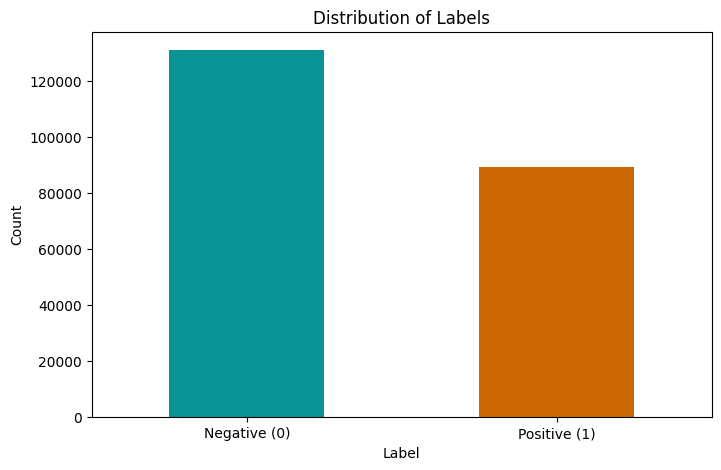

In [7]:
print(f"Number of Training Images: \n{len(os.listdir(train_dir))}")
print(f"\nNumber of Testing Images: \n{len(os.listdir(test_dir))}")
print(f"\nNumber of Training Labels: \n{train_labels.shape[0]}")
print(f"\nMissing Training Label Values: \n{train_labels.isnull().sum()}")

label_distribution = train_labels["label"].value_counts()
label_distribution.plot(kind="bar", color=colors, figsize=(8, 5))
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"], rotation=0)
plt.show()

The data availability and completeness all look great, as I expected. However, there is an imbalance of labels, with many more negative examples than positive examples in the training dataset. I might need to use class weighting to ensure the model does not overfit and could also augment the dataset if needed.

Next, I'll look at the images themselves to determine what transformation layers we will need and to see if benign/malignant images have any obvious visual indicators.

In [8]:
img = Image.open(train_dir + os.listdir(train_dir)[40])

print(
    f"Image Details:\n\nSize: {img.size}\nMode: {img.mode}\nShape: {np.array(img).shape}"
)

Image Details:

Size: (96, 96)
Mode: RGB
Shape: (96, 96, 3)


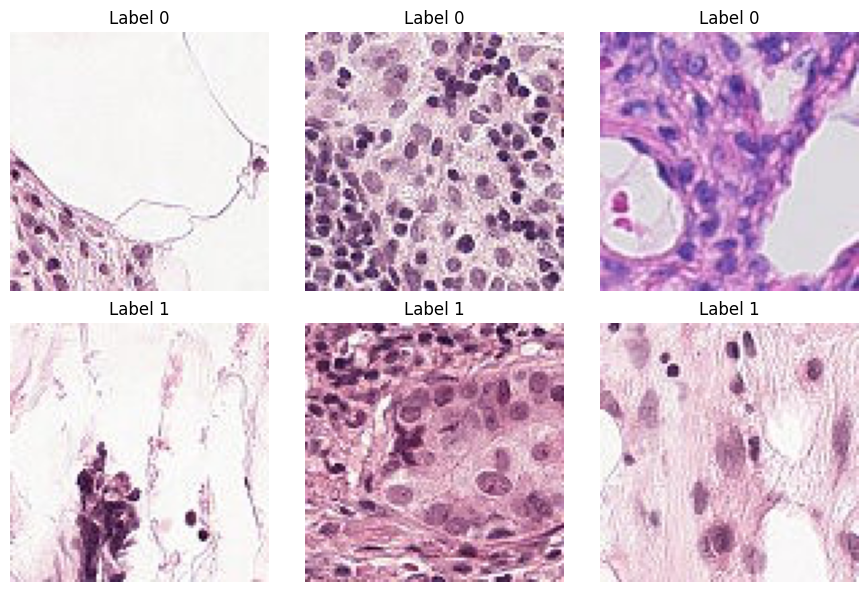

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for i in range(3):
    id_0 = train_labels[train_labels["label"] == 0].iloc[i]["id"]
    id_1 = train_labels[train_labels["label"] == 1].iloc[i]["id"]

    image_0 = mpimg.imread(f"{train_dir}{id_0}.tif")
    image_1 = mpimg.imread(f"{train_dir}{id_1}.tif")

    axes[0, i].imshow(image_0)
    axes[0, i].set_title(f"Label 0")
    axes[0, i].axis("off")

    axes[1, i].imshow(image_1)
    axes[1, i].set_title(f"Label 1")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

Given that I have zero domain expertise in this area, I honestly do not see any characteristics in these images that would help identify metastatic tissue in general. Perhaps I will need to use **feature engineering** to enhance color and texture differences for the model.

The model is supposed to be based on the inner 32x32 section of images; I'll display that just to visualize.

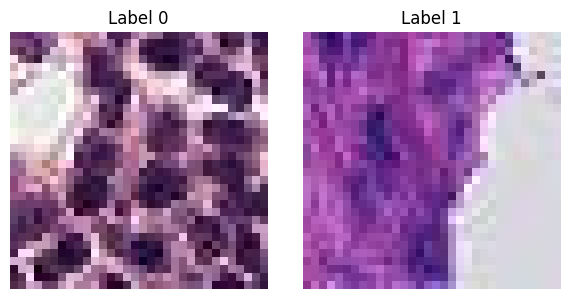

In [10]:
id_0 = train_labels[train_labels["label"] == 0].iloc[10]["id"]
id_1 = train_labels[train_labels["label"] == 1].iloc[10]["id"]

img_0 = Image.open(train_dir + id_0 + ".tif")
img_1 = Image.open(train_dir + id_1 + ".tif")

width, height = img.size
left = (width - 32) // 2
top = (height - 32) // 2
right = left + 32
bottom = top + 32

cropped_img_0 = img_0.crop((left, top, right, bottom))
cropped_img_1 = img_1.crop((left, top, right, bottom))

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(cropped_img_0)
axes[0].set_title("Label 0")
axes[0].axis("off")

axes[1].imshow(cropped_img_1)
axes[1].set_title("Label 1")
axes[1].axis("off")

plt.tight_layout()
plt.show()

I can also sample the pixel density distribution to understand what normalization techniques could improve model performance.

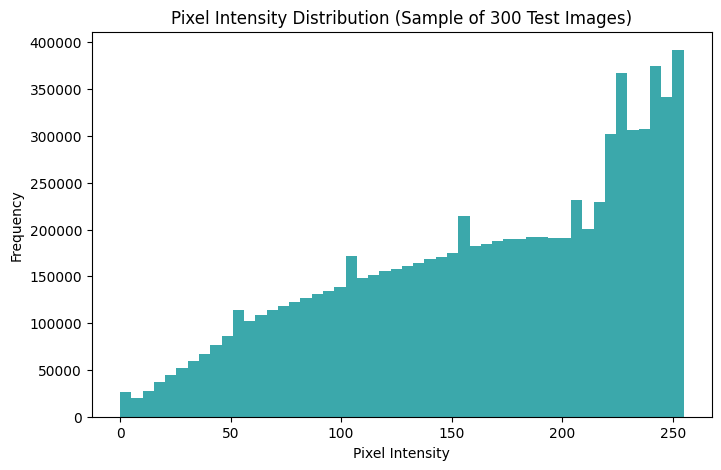

In [11]:
test_image_files = random.sample(os.listdir(test_dir), 300)

pixel_values = []
for fname in test_image_files:
    img = Image.open(f"{test_dir}{fname}")
    arr = np.array(img)
    pixel_values.append(arr.flatten())

pixel_values = np.concatenate(pixel_values)
plt.figure(figsize=(8, 5))
plt.hist(pixel_values, bins=50, color=colors[0], alpha=0.8)
plt.title("Pixel Intensity Distribution (Sample of 300 Test Images)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

---
## Summary

To summarize, we have a wide variety of images with a wide variety of colors and no visually recognizable pattern to make assumptions about how models could better make predictions. It's very likely **contrast enhancement** may improve model performance. We will also need to take a very small sample of data to experiment with model architectures and hyperparameters.

In [12]:
def load_image(iid, image_dir=train_dir):
    path = image_dir + "/" + iid + ".tif"

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


n_train_subset = int(train_labels.shape[0] * 0.05)

negative = train_labels[train_labels["label"] == 0].sample(n_train_subset)
positive = train_labels[train_labels["label"] == 1].sample(n_train_subset)
neg_and_pos = pd.concat([negative, positive], axis=0).reset_index(drop=True)

train_labels_subset = neg_and_pos.sample(frac=1).reset_index(drop=True)

X_subset = np.array([load_image(i) for i in train_labels_subset["id"]])
y_subset = train_labels_subset["label"].values

## Model Architecture

We can experiment with two models. The first model will be a standard CNN using feature maps for feature tuning like I discussed in EDA, and we will perform some hyperparameter search tuning. For the second model, I would like to try and use transfer learning.

In [13]:
input_shape = np.array(img).shape
num_classes = 1


def build_model_1(hp):
    model = models.Sequential(
        [
            layers.Input(shape=input_shape),
            # Normalize and Crop
            layers.Rescaling(1.0 / 255),
            layers.Cropping2D(cropping=32),
            # CNN Feature Maps
            layers.Conv2D(32, (3, 3), activation="relu"),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(
                hp.Int("conv_units", 64, 128, step=64), (3, 3), activation="relu"
            ),
            layers.MaxPooling2D(2, 2),
            # Fully Connected Layer and Prevent Overfitting with Dropout
            layers.Flatten(),
            layers.Dense(hp.Int("dense_units", 128, 256, step=128), activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        optimizer=optimizers.Adam(hp.Choice("learning_rate", [1e-4, 1e-3])),
        loss="binary_crossentropy",
        metrics=["accuracy", "auc"],
    )

    return model


cnn_1_tuner = kt.RandomSearch(
    build_model_1, objective="val_accuracy", directory="tuning_1"
)

cnn_1_tuner.search(X_subset, y_subset, validation_split=0.2, epochs=10)
cnn_1_model = cnn_1_tuner.get_best_models(num_models=1)[0]
cnn_1_model.summary()

Trial 7 Complete [00h 00m 45s]
val_accuracy: 0.7720972299575806

Best val_accuracy So Far: 0.7775505781173706
Total elapsed time: 00h 05m 11s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,218,049 (4.65 MB)

 Trainable params: 1,218,049 (4.65 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
loss, accuracy, auc = cnn_1_model.evaluate(X_subset, y_subset)

print(f"CNN Model Evaluation on Subset:")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8219 - auc: 0.8968 - loss: 0.4081
CNN Model Evaluation on Subset:
Loss: 0.4190
Accuracy: 0.8154
AUC: 0.8905


For a second model, I attempted to use transfer learning based on the ResNet50 model, but I was unable to achieve acceptable performance. From my research, it seems the primary issue was how small these images are, but scaling them up to ResNet50's training dimensions only marginally raised my accuracy. After some more experimenting, I ran out of time and decided this could be a good follow-up project.

In [15]:
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False

model_resnet = models.Sequential(
    [
        layers.Input(shape=input_shape),
        layers.Rescaling(1.0 / 255),
        layers.Cropping2D(cropping=32),
        base_model,
        # Add new layers for classification
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", "auc"],
)
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_1 (Cropping2D)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
loss, accuracy, auc = model_resnet.evaluate(X_subset, y_subset)

print(f"ResNet Model Evaluation on Subset:")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

688/688 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4971 - auc: 0.5214 - loss: 0.9252
ResNet Model Evaluation on Subset:
Loss: 0.9216
Accuracy: 0.5000
AUC: 0.5149


---
Because my custom CNN model performed so much better than the transfer learning model, I'll train it on the full training dataset for my submission.

In [17]:
def data_generator(image_ids, labels, image_dir, batch_size):
    while True:
        batch_ids = random.sample(image_ids, batch_size)
        batch_images = np.array([load_image(iid, image_dir) for iid in batch_ids])
        batch_labels = np.array([labels[iid] for iid in batch_ids])
        yield batch_images, batch_labels


train_labels_dict = dict(zip(train_labels["id"], train_labels["label"]))
all_train_image_ids = [fname.replace(".tif", "") for fname in os.listdir(train_dir)]

batch_size = 32
epochs = 20
steps_per_epoch = len(all_train_image_ids) // batch_size

history_cnn_full = cnn_1_model.fit(
    data_generator(all_train_image_ids, train_labels_dict, train_dir, batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
)

Epoch 1/20
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 181s 26ms/step - accuracy: 0.7918 - auc: 0.8554 - loss: 0.4613
Epoch 2/20
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 135s 20ms/step - accuracy: 0.8057 - auc: 0.8729 - loss: 0.4342
Epoch 3/20
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 115s 17ms/step - accuracy: 0.8152 - auc: 0.8827 - loss: 0.4183
Epoch 4/20
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 117s 17ms/step - accuracy: 0.8236 - auc: 0.8905 - loss: 0.4043
Epoch 5/20
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 116s 17ms/step - accuracy: 0.8315 - auc: 0.9001 - loss: 0.3889
Epoch 6/20
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 115s 17ms/step - accuracy: 0.8390 - auc: 0.9085 - loss: 0.3731
Epoch 7/20
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 116s 17ms/step - accuracy: 0.8497 - auc: 0.9161 - loss: 0.3581
Epoch 8/20
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 116s 17ms/step - accuracy: 0.8577 - auc: 0.9249 - loss: 0.3397
Epoch 9/20
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 116s 17ms/step - accuracy: 0.8638 - auc: 0.9320 - loss: 0.3229
Epoch 10/20
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 116s 17ms/st

## Results and Analysis

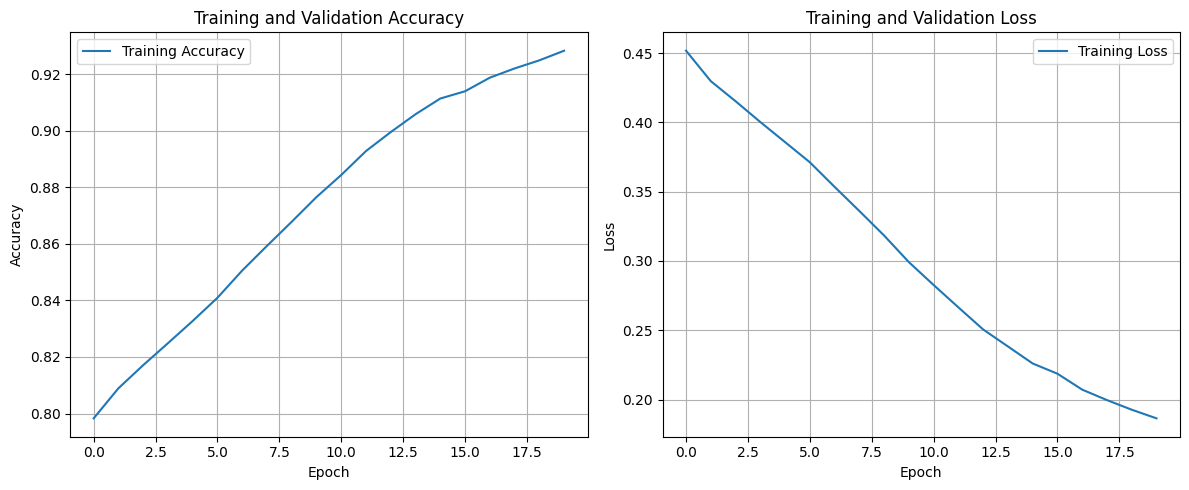

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_full.history["accuracy"], label="Training Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_cnn_full.history["loss"], label="Training Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

---
Training accuracy and loss were both still trending in the right direction, so I believe this model would have continued to improve for a few more epochs. It's obviously performing better than random guessing (it would have a strong ROC curve) and can effectively distinguish between the two classes.

To improve this model, you could experiment with more **hyperparameter tuning** and train the final model for more epochs with **early stopping**.

In [21]:
test_image_files = [f for f in os.listdir(test_dir) if f.endswith(".tif")]
test_ids = [f.replace(".tif", "") for f in test_image_files]
test_images = np.array([load_image(iid, test_dir) for iid in test_ids])

predictions = cnn_1_model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int).flatten()
submission_df = pd.DataFrame({"id": test_ids, "label": predicted_labels})
submission_file_path = "submission_cnn1.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file '{submission_file_path}' generated successfully.")
print("\nSample of the submission file:")
print(submission_df.head())

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Submission file 'submission_cnn1.csv' generated successfully.

Sample of the submission file:
                                         id  label
0  d751307df11d902f28fab571d7aa8cf889148d5e      1
1  62ee78062e98a8041451d507f9b39cf706a797c6      0
2  a4a6a63dd84bc88ba13dde3223e9e281f1b29254      1
3  0c4ed321a19bf5cbd1c4ae48d6d0b7b000492b08      0
4  93b6fd30b8afc3a9ad976b480ece7150eaddc1f7      0


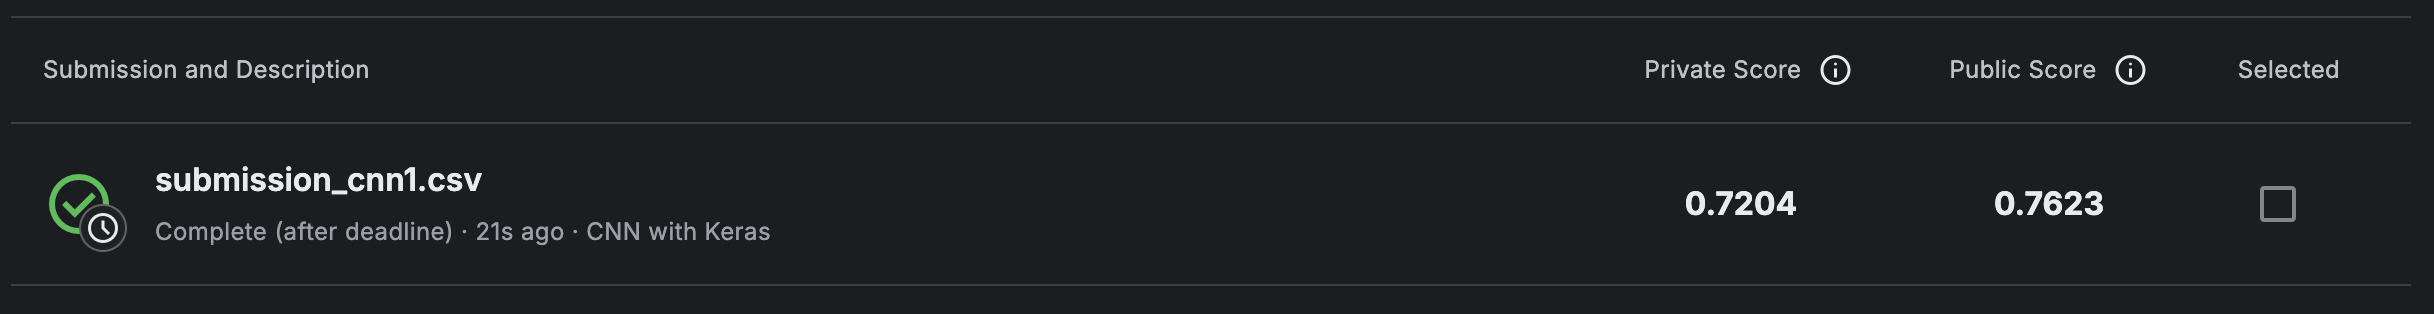

## Conclusion

Overall, my CNN model was able to perform well because of the feature engineering performed on the images to normalize the data and reduce the variance of pixel density. It did not appear that the CNN model was overfitting, due to the positive trend in loss over the full training session.

I believe training the final model with more epochs would have resulted in better final performance.

I really struggled to build an effective model using transfer learning. Image scaling and feature engineering were not effective for improving the performance, so further experimentation would be needed to discover the bottleneck in that approach.

I learned that deep learning models thrive on data and compute power, and that made this project uniquely challenging for me.

For next steps, I would experiment more with hyperparameters and attempt adding an additional layer to my CNN model to improve performance.